<a href="https://colab.research.google.com/github/jnsbrdbr/thesis/blob/thesis/part5_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.0


In [2]:
import keras
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
!pip install --upgrade tables

In [5]:
with pd.HDFStore('/content/drive/MyDrive/1000/part2_result',  mode='r') as newstore:
    result = newstore.select('result')

In [6]:
#final data
print(result)

             0         1         2  ...         8         9  label
0    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
1    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
2    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
3    -1.680599 -3.061217 -0.040984  ... -0.006112 -0.004759      1
4    -1.680599 -3.061217 -0.040984  ...  0.006186  0.002988      1
...        ...       ...       ...  ...       ...       ...    ...
1315 -1.680599 -3.061217 -0.040984  ... -0.035323 -0.015205      0
1316 -1.680599 -3.061217 -0.040984  ... -0.012077 -0.016767      0
1317 -1.680599 -3.061217 -0.040984  ... -0.011761 -0.013474      0
1318 -1.680599 -3.061217 -0.040984  ...  0.004503  0.113459      0
1319 -1.680599 -3.061217 -0.040984  ... -0.022880  0.001418      0

[1320 rows x 71 columns]


In [7]:
#divide data in to data_label and non_data label

import copy
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel
y=result.label

In [8]:
#splitting data in to test and train...

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=42,test_size=0.3)#

In [9]:
print('shape of x_train is:',X_train.shape)
print('shape of x_test is:',X_test.shape)

shape of x_train is: (924, 70)
shape of x_test is: (396, 70)


In [10]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [11]:
make_latent_samples(1, 300) # generates one sample

array([[-0.73150552,  1.33172048,  0.4163271 ,  0.50449136, -1.93562901,
        -1.40845427,  1.1652469 ,  0.43486334,  0.58284322,  0.86414526,
        -0.13805829, -0.54632018,  0.23144703,  0.19021732,  0.78275686,
         1.54719768, -0.36388275,  3.05286406,  1.04601088,  0.15694474,
        -1.08499705, -1.22646562,  2.1658339 ,  1.0613744 ,  1.87399144,
        -0.48526297, -1.52921251,  0.80217528,  1.31594834, -0.5656184 ,
        -0.31936377, -1.1537824 , -0.03657154,  0.72205726,  0.72845352,
         0.82313665,  0.6314742 , -0.49975641,  0.78064688, -0.44711851,
        -0.53440229, -0.13398961, -1.1992488 , -0.18203325, -0.43114363,
         0.11810747, -0.20169356,  1.54230404,  0.18839616, -0.772211  ,
         0.12178653, -0.20937574, -0.90440306,  0.15758516, -0.66475403,
        -0.21407281, -0.77400745, -0.46648442,  1.23891443, -0.36938108,
        -0.33486423, -0.29097231, -1.07121118,  0.05108564, -0.44118935,
         0.84899221,  2.04797034, -1.08953823,  0.7

In [13]:
generator = Sequential([
    Dense(256, input_shape=(300,)),
    LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(512),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(256),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(128),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    Dense(70),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               77056     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 70)                17990     
                                                                 
 activation_1 (Activation)   (None, 70)                0         
                                                                 
Total params: 95,046
Trainable params: 95,046
Non-trainable params: 0
_________________________________________________________________


In [14]:
discriminator = Sequential([
    Dense(128, input_shape=(70,)),
    LeakyReLU(alpha=0.02),
    #(momentum=0.6),
    Dense(64),
    LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    Dense(32),
    LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(16),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(8),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)               

In [15]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 70)                95046     
                                                                 
 discriminator (Sequential)  (None, 1)                 19457     
                                                                 
Total params: 114,503
Trainable params: 114,503
Non-trainable params: 0
_________________________________________________________________


In [16]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [17]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)               

In [18]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               9088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)               

In [28]:
def make_simple_GAN(sample_size, 
                    g_hidden_size_1,
                    g_hidden_size_2,
                    g_hidden_size_3,
                    g_hidden_size_4,
                    d_hidden_size_1,
                    d_hidden_size_2, 
                    d_hidden_size_3,
                    d_hidden_size_4,
                    d_hidden_size_5,
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size_1, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_2),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_3),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(70),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size_1, input_shape=(70,)),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_2),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_3),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(d_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(d_hidden_size_5),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

In [20]:
from sklearn import preprocessing
def preprocess(x):
   x = preprocessing.scale(x)
   return x

In [21]:
X_train_real = np.array(preprocess(X_train))
X_test_real  = np.array(preprocess(X_test))

In [22]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [23]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [24]:
# hyperparameters
sample_size     = 300     # latent sample size (i.e., 100 random numbers)
g_hidden_size_1 = 256
g_hidden_size_2 = 0
g_hidden_size_3 = 0
g_hidden_size_4 = 0
d_hidden_size_1 = 128
d_hidden_size_2 = 64
d_hidden_size_3 = 32
d_hidden_size_4 = 16
d_hidden_size_5 = 8
leaky_alpha     = 0.02
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 150
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1


In [29]:
## labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size_1, 
    g_hidden_size_2,
    g_hidden_size_3,
    g_hidden_size_4, 
    d_hidden_size_1, 
    d_hidden_size_2,
    d_hidden_size_3,
    d_hidden_size_4,
    d_hidden_size_5,
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)


losses = []
losses1 = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
   # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))

    #d_acc_real = discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    #d_acc_fake = discriminator.train_on_batch(X_batch_fake, y_train_fake)
    #d_acc  = 0.5 * (d_acc_real + d_acc_fake)

    #losses1.append(( d_acc))
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f} ".format(
        e+1, epochs, d_loss, g_loss)) #Discriminator acc: {:>6.4f}:,d_acc

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch:   1/150 Discriminator Loss: 0.5645 Generator Loss: 1.3570 
Epoch:   2/150 Discriminator Loss: 0.2912 Generator Loss: 2.2975 
Epoch:   3/150 Discriminator Loss: 0.4550 Generator Loss: 2.5008 
Epoch:   4/150 Discriminator Loss: 0.2783 Generator Loss: 2.8621 
Epoch:   5/150 Discriminator Loss: 0.5871 Generator Loss: 2.5311 
Epoch:   6/150 Discriminator Loss: 0.4102 Generator Loss: 3.0905 
Epoch:   7/150 Discriminator Loss: 0.4816 Generator Loss: 2.7814 
Epoch:   8/150 Discriminator Loss: 0.6614 Generator Loss: 2.7567 
Epoch:   9/150 Discriminator Loss: 0.4422 Generator Loss: 3.2214 
Epoch:  10/150 Discriminator Loss: 0.4185 Generator Loss: 3.2706 
Epoch:  11/150 Discriminator Loss: 0.4466 Generator Loss: 3.5797 
Epoch:  12/150 Discriminator Loss: 0.3547 Generator Loss: 4.5955 
Epoch:  13/150 Discriminator Loss: 0.4913 Generator Loss: 4.5343 
Epoch:  14/150 Discriminator Loss: 0.1606 Generator Loss: 4.7370 
Epoch:  15/150 Discriminator Loss: 0.9320 Generator Loss: 4.9323 
Epoch:  16

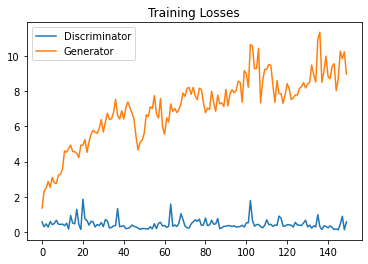

In [30]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [31]:
rr = discriminator.predict_on_batch(X_test_real)

In [32]:
import keras
#import keras_metrics

r = tf.keras.metrics.Recall()#thresholds=rr.min())
r.update_state(y_test,rr )
r.result().numpy()


0.86333334

In [33]:
p=tf.keras.metrics.Precision()#thresholds=rr.min())
p.update_state(y_test,rr )
p.result().numpy()

0.73789173